# Mask R-CNN - Train on Nuclei Dataset


This notebook shows how to train Mask R-CNN on nuclei dataset. There's the need of a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. 

Must be downloaded the dataset of Data Science Bowl 2018

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

from config import Config
import utils
import model as modellib
import visualize
from model import log

%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logsNuclei")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

Using Theano backend.


RuntimeError: To use MKL 2018 with Theano you MUST set "MKL_THREADING_LAYER=GNU" in your environement.

# Configurations

In [75]:
class NucleiConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "shapes"
    train_path="C:\\Users\\caperei\\OneDrive - Microsoft\\PROJECTS\\Github\\Mask_RCNN\\Nuclei_stage1_train"
    test_path="C:\\Users\\caperei\\OneDrive - Microsoft\\PROJECTS\\Github\\Mask_RCNN\\Nuclei_stage1_test"
    path_aux_im="images"
    path_aux_mas="masks"
    count_train=len([name for name in os.listdir(train_path)])
    count_test=len([name for name in os.listdir(test_path)])
    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + 3  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = NucleiConfig()
config.display()


Configurations:
BACKBONE_SHAPES                [[32 32]
 [16 16]
 [ 8  8]
 [ 4  4]
 [ 2  2]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [ 0.1  0.1  0.2  0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 8
IMAGE_MAX_DIM                  128
IMAGE_MIN_DIM                  128
IMAGE_PADDING                  True
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [ 123.7  116.8  103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           shapes
NUM_CLASSES                    4
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_TRAINING         20

In [28]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [150]:
class NucleiDataset(utils.Dataset):
    """Generates the shapes synthetic dataset. The dataset consists of simple
    shapes (triangles, squares, circles) placed randomly on a blank surface.
    The images are generated on the fly. No file access required.
    """

    def load_nuclei(self, count, image_path):
        """Generate the requested number of synthetic images.
        count: number of images to generate.
        height, width: the size of the generated images.
        """
        #count=number of images to load (put as a conf, count of items in the folder)
        
        # Add classes
        self.add_class("nuclei", 1, "nucleus")
        

        # Add images
        # Generate random specifications of images (i.e. color and
        # list of shapes sizes and locations). This is more compact than
        # actual images. Images are generated on the fly in load_image().
        
        i=0 
        for name in os.listdir(image_path):
            self.add_image("nuclei", image_id=i,name=name, path=image_path+"\\"+name+"\\images\\"+name+".png")
            i+=1

    def load_image(self, image_id):
        """Generate an image from the specs of the given image ID.
        Typically this function loads the image from a file, but
        in this case it generates the image on the fly from the
        specs in image_info.
        """
        info = self.image_info[image_id]
        image = skimage.io.imread(info["path"])
                                
        # If grayscale. Convert to RGB for consistency.
        if image.ndim != 3:
            image = skimage.color.gray2rgb(image)
        return image

    def image_reference(self, image_id):
        """Return a link to the image in the nuclei folder."""
        info = self.image_info[image_id]
        if info["source"] == "nuclei":
            return self.info["path"]
        else:
            super(CocoDataset, self).image_reference(image_id)

    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        info = self.image_info[image_id]
        i=1
        while i<=1:
            for file in os.listdir(os.path.join(config.train_path,info["name"],config.path_aux_mas)):
                aux=skimage.io.imread(os.path.join(config.train_path,info["name"],config.path_aux_mas, file))
                height=aux.shape[0]
                width=aux.shape[1]
                c=len([name for name in os.path.join(config.train_path,info["name"],config.path_aux_mas)])
                i=2
                
                
        mask=np.zeros((height,width,c))
        i=0
        for file in os.listdir(os.path.join(config.train_path,info["name"],config.path_aux_mas)):
            if file.endswith(".png"):
                
                pre_mask=skimage.io.imread(os.path.join(config.train_path,info["name"],config.path_aux_mas, file))
                
                mask[:,:,i]=pre_mask[:,:]
                i+=1
        class_ids=np.ones(i-1).astype(np.int32)                      
                                  
        return mask, class_ids
   

In [151]:
# Training dataset
dataset_train = NucleiDataset()
dataset_train.load_nuclei(config.count_train, config.train_path)
dataset_train.prepare()

# Validation dataset
dataset_val = NucleiDataset()
dataset_val.load_nuclei(config.count_test, config.test_path)
dataset_val.prepare()

473


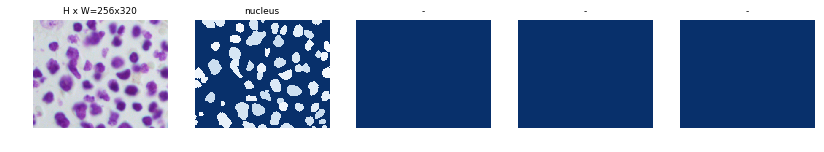

279


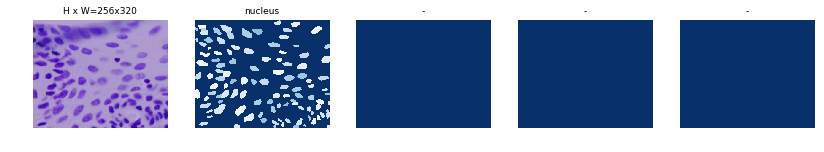

588


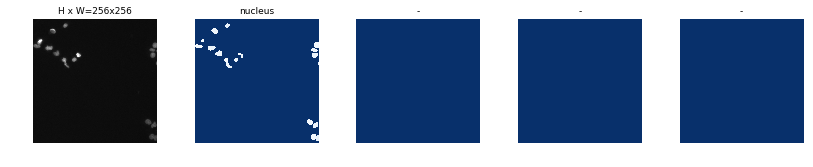

426


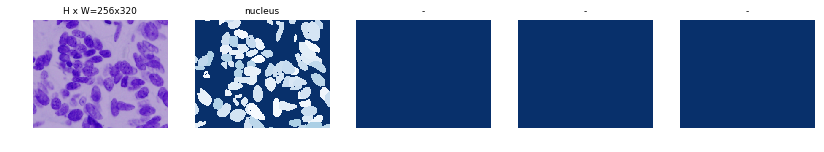

In [152]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

# Create Model

(520, 696, 4)


C:\Users\caperei\AppData\Local\Continuum\anaconda3\envs\newenv\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


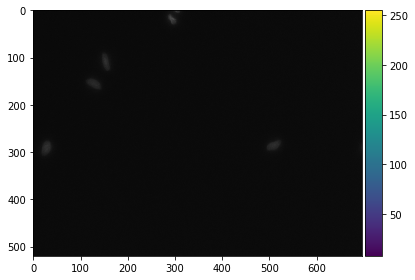

In [83]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [ ]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [ ]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')

In [ ]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=2, 
            layers="all")

In [ ]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
# model.keras_model.save_weights(model_path)

## Detection

In [ ]:
class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()[1]

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

In [ ]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

In [ ]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Evaluation

In [ ]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id,
                         r["rois"], r["class_ids"], r["scores"])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))